copy from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_combine_GPT4o_with_RAG_Outfit_Assistant.ipynb

In [1]:
%pip install openai
%pip install tenacity
%pip install tqdm
%pip install numpy
%pip install typing
%pip install tiktoken
%pip install concurrent
%pip install panda --quiet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the require

In [2]:
import pandas as pd
import numpy as np
import json
import ast
import tiktoken
import concurrent
from openai import OpenAI
from tqdm import tqdm
from tenacity import retry, wait_random_exponential, stop_after_attempt
from IPython.display import Image, display, HTML
from typing import List


In [3]:

client = OpenAI(api_key="")

GPT_MODEL = "gpt-4o-mini"
EMBEDDING_MODEL = "text-embedding-3-large"
EMBEDDING_COST_PER_1K_TOKENS = 0.00013

# 임베딩 방법

In [4]:
## Batch Embedding Logic

# Simple function to take in a list of text objects and return them as a list of embeddings
@retry(wait=wait_random_exponential(min=1, max=40), stop=stop_after_attempt(10))
def get_embeddings(input: List):
    response = client.embeddings.create(
        input=input,
        model=EMBEDDING_MODEL
    ).data
    return [data.embedding for data in response]


# Splits an iterable into batches of size n.
def batchify(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx : min(ndx + n, l)]
     

# Function for batching and parallel processing the embeddings
def embed_corpus(
    corpus: List[str],
    batch_size=64,
    num_workers=8,
    max_context_len=8191,
):
    # Encode the corpus, truncating to max_context_len
    encoding = tiktoken.get_encoding("cl100k_base")
    encoded_corpus = [
        encoded_article[:max_context_len] for encoded_article in encoding.encode_batch(corpus)
    ]

    # Calculate corpus statistics: the number of inputs, the total number of tokens, and the estimated cost to embed
    num_tokens = sum(len(article) for article in encoded_corpus)
    cost_to_embed_tokens = num_tokens / 1000 * EMBEDDING_COST_PER_1K_TOKENS
    print(
        f"num_articles={len(encoded_corpus)}, num_tokens={num_tokens}, est_embedding_cost={cost_to_embed_tokens:.2f} USD"
    )

    # Embed the corpus
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        
        futures = [
            executor.submit(get_embeddings, text_batch)
            for text_batch in batchify(encoded_corpus, batch_size)
        ]

        with tqdm(total=len(encoded_corpus)) as pbar:
            for _ in concurrent.futures.as_completed(futures):
                pbar.update(batch_size)

        embeddings = []
        for future in futures:
            data = future.result()
            embeddings.extend(data)

        return embeddings


In [64]:
texts = [
    "오늘 날씨가 정말 좋네요.", 
    "지난주 여행이 너무 좋았어요.",
    "친구들과 맛있는 저녁을 먹었습니다.",
    "새로 산 옷이 마음에 들어요.",
    "강아지와 산책하는 게 최고에요.",
    "아침에 산책하는 것이 좋은 습관이네요.",
    "복숭아가 제철이라고 하더라고요.",
    "이번 달부터 운동을 시작했습니다.",
    "음악을 들으며 공부하는 게 좋더라고요.",
    "내일 회사 회식이 있어요."
]
embeddings = embed_corpus(texts)

num_articles=10, num_tokens=185, est_embedding_cost=0.00 USD


64it [00:00, 123.08it/s]              


In [69]:
print(len(embeddings[0]))
print(embeddings[0])

3072
[0.04136071354150772, -0.0003067170619033277, -0.003541338723152876, 0.00693412683904171, 0.021752042695879936, 0.004679341800510883, -0.019025079905986786, 0.017900340259075165, 0.003530727932229638, -0.0029657052364200354, -0.002490874147042632, 0.01624506153166294, 0.056534089148044586, -0.004132888279855251, -0.024489616975188255, 0.01818682998418808, -0.012658627703785896, -0.03488815575838089, 0.0013289967318996787, -0.018611259758472443, -0.030495302751660347, 0.02125333622097969, 0.02045753039419651, 0.0545392669737339, -0.023216325789690018, -0.0009184932569041848, -0.0032919859513640404, 0.040066201239824295, 0.031238054856657982, -0.004392851609736681, 0.011990150436758995, 0.039853986352682114, 0.006350535433739424, 0.011682438664138317, -0.0021062344312667847, 0.0065362234599888325, 0.01312550064176321, 0.013199776411056519, 0.026314666494727135, 0.023343656212091446, -0.034845709800720215, 0.005517591256648302, -0.027078639715909958, 0.011120068840682507, 0.030686296

In [67]:
def cosine_similarity_manual(vec1, vec2):
    """Calculate the cosine similarity between two vectors."""
    vec1 = np.array(vec1, dtype=float)
    vec2 = np.array(vec2, dtype=float)


    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)


def find_similar_items(input_embedding, embeddings, threshold=0.0, top_k=5):
    """Find the most similar items based on cosine similarity."""
    
    # Calculate cosine similarity between the input embedding and all other embeddings
    similarities = [(index, cosine_similarity_manual(input_embedding, vec)) for index, vec in enumerate(embeddings)]
    
    # Filter out any similarities below the threshold
    filtered_similarities = [(index, sim) for index, sim in similarities if sim >= threshold]
    
    # Sort the filtered similarities by similarity score
    sorted_indices = sorted(filtered_similarities, key=lambda x: x[1], reverse=True)
    
    return sorted_indices[1:top_k+1]


target_index = 0
print(texts[target_index])

similar_indices = find_similar_items(embeddings[target_index], embeddings)
print(similar_indices)
simlar_index = similar_indices[0][0]
print(texts[simlar_index])

오늘 날씨가 정말 좋네요.
[(5, np.float64(0.380804009824038)), (1, np.float64(0.3757489467274296)), (3, np.float64(0.33756197318626524)), (4, np.float64(0.329063147269134)), (2, np.float64(0.30447011378550815))]
아침에 산책하는 것이 좋은 습관이네요.


# 데이터 준비

다운로드

In [36]:
!wget https://raw.githubusercontent.com/dhrim/2024_openai_api_seminar/main/data/sample_clothes.zip -O sample_clothes.zip

--2024-08-07 08:17:24--  https://raw.githubusercontent.com/dhrim/2024_openai_api_seminar/main/data/sample_clothes.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 31958345 (30M) [application/zip]
Saving to: ‘sample_clothes.zip’

sample_clothes.zip  100%[===================>]  30.48M   192MB/s    in 0.2s    

2024-08-07 08:17:25 (192 MB/s) - ‘sample_clothes.zip’ saved [31958345/31958345]



압축 풀기

In [37]:
!unzip sample_clothes.zip

Archive:  sample_clothes.zip
   creating: sample_clothes/
  inflating: sample_clothes/sample_styles.csv  
   creating: sample_clothes/sample_images/
  inflating: sample_clothes/sample_styles_with_embeddings.csv  


  inflating: sample_clothes/sample_images/30797.jpg  
  inflating: sample_clothes/sample_images/10453.jpg  
  inflating: sample_clothes/sample_images/52106.jpg  
  inflating: sample_clothes/sample_images/31338.jpg  
  inflating: sample_clothes/sample_images/2841.jpg  
  inflating: sample_clothes/sample_images/52476.jpg  
  inflating: sample_clothes/sample_images/12052.jpg  
  inflating: sample_clothes/sample_images/34081.jpg  
  inflating: sample_clothes/sample_images/48360.jpg  
  inflating: sample_clothes/sample_images/4968.jpg  
  inflating: sample_clothes/sample_images/32427.jpg  
  inflating: sample_clothes/sample_images/19846.jpg  
  inflating: sample_clothes/sample_images/19852.jpg  
  inflating: sample_clothes/sample_images/32590.jpg  
  inflating: sample_clothes/sample_images/7454.jpg  
  inflating: sample_clothes/sample_images/20802.jpg  
  inflating: sample_clothes/sample_images/36735.jpg  
  inflating: sample_clothes/sample_images/26526.jpg  
  inflating: sample_clothes/sa

In [38]:
styles_filepath = "sample_clothes/sample_styles.csv"
styles_df = pd.read_csv(styles_filepath, on_bad_lines='skip')
print(styles_df.head())
print("Opened dataset successfully. Dataset has {} items of clothing.".format(len(styles_df)))

      id gender masterCategory subCategory articleType baseColour  season  \
0  27152    Men        Apparel     Topwear      Shirts       Blue  Summer   
1  10469    Men        Apparel     Topwear     Tshirts     Yellow    Fall   
2  17169    Men        Apparel     Topwear      Shirts     Maroon    Fall   
3  56702    Men        Apparel     Topwear      Kurtas       Blue  Summer   
4  47062  Women        Apparel  Bottomwear     Patiala      Multi    Fall   

     year   usage                       productDisplayName  
0  2012.0  Formal       Mark Taylor Men Striped Blue Shirt  
1  2011.0  Casual   Flying Machine Men Yellow Polo Tshirts  
2  2011.0  Casual  U.S. Polo Assn. Men Checks Maroon Shirt  
3  2012.0  Ethnic                  Fabindia Men Blue Kurta  
4  2012.0  Ethnic        Shree Women Multi Colored Patiala  
Opened dataset successfully. Dataset has 1000 items of clothing.


데이터 읽기

옷 설명을 임베딩한 값이 포함되어 있다.

In [39]:
styles_df = pd.read_csv('sample_clothes/sample_styles_with_embeddings.csv', on_bad_lines='skip')

# Convert the 'embeddings' column from string representations of lists to actual lists of floats
styles_df['embeddings'] = styles_df['embeddings'].apply(lambda x: ast.literal_eval(x))

print(styles_df.head())
print("Opened dataset successfully. Dataset has {} items of clothing along with their embeddings.".format(len(styles_df)))

      id gender masterCategory subCategory articleType baseColour  season  \
0  27152    Men        Apparel     Topwear      Shirts       Blue  Summer   
1  10469    Men        Apparel     Topwear     Tshirts     Yellow    Fall   
2  17169    Men        Apparel     Topwear      Shirts     Maroon    Fall   
3  56702    Men        Apparel     Topwear      Kurtas       Blue  Summer   
4  47062  Women        Apparel  Bottomwear     Patiala      Multi    Fall   

     year   usage                       productDisplayName  \
0  2012.0  Formal       Mark Taylor Men Striped Blue Shirt   
1  2011.0  Casual   Flying Machine Men Yellow Polo Tshirts   
2  2011.0  Casual  U.S. Polo Assn. Men Checks Maroon Shirt   
3  2012.0  Ethnic                  Fabindia Men Blue Kurta   
4  2012.0  Ethnic        Shree Women Multi Colored Patiala   

                                          embeddings  
0  [0.006910496857017279, 0.0002929018228314817, ...  
1  [-0.0437035895884037, -0.008875241503119469, -...  

# 이미지 분석

분석 호출 함수

이미지를 입력으로 이와 잘 어울릴 옷에 대한 설명을 구한다.

In [20]:
def analyze_image(image_base64, subcategories):
    response = client.chat.completions.create(
        model=GPT_MODEL,
        messages=[
            {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": """Given an image of an item of clothing, analyze the item and generate a JSON output with the following fields: "items", "category", and "gender". 
                           Use your understanding of fashion trends, styles, and gender preferences to provide accurate and relevant suggestions for how to complete the outfit.
                           The items field should be a list of items that would go well with the item in the picture. Each item should represent a title of an item of clothing that contains the style, color, and gender of the item.
                           The category needs to be chosen between the types in this list: {subcategories}.
                           You have to choose between the genders in this list: [Men, Women, Boys, Girls, Unisex]
                           Do not include the description of the item in the picture. Do not include the ```json ``` tag in the output.
                           
                           Example Input: An image representing a black leather jacket.

                           Example Output: {"items": ["Fitted White Women's T-shirt", "White Canvas Sneakers", "Women's Black Skinny Jeans"], "category": "Jackets", "gender": "Women"}
                           """,
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{image_base64}",
                },
                }
            ],
            }
        ]
    )
    # Extract relevant features from the response
    features = response.choices[0].message.content
    return features

In [21]:
import base64

def encode_image_to_base64(image_path):
    with open(image_path, 'rb') as image_file:
        encoded_image = base64.b64encode(image_file.read())
        return encoded_image.decode('utf-8')

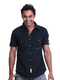

In [52]:
# Set the path to the images and select a test image
image_path = "sample_clothes/sample_images/"

# Encode the test image to base64
reference_image = image_path + "2133.jpg"
encoded_image = encode_image_to_base64(reference_image)
display(Image(filename=reference_image))

옷 종류

In [26]:
unique_subcategories = styles_df['articleType'].unique()

print(unique_subcategories)

['Shirts' 'Tshirts' 'Kurtas']


분석 실행

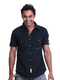

위 옷과 잘 어울릴 옷 종류
{'items': ["Light Grey Men's Chinos", 'White Casual Sneakers', 'Navy Blue Lightweight Jacket'], 'category': 'Shirts', 'gender': 'Men'}


In [53]:

# Analyze the image and return the results
analysis = analyze_image(encoded_image, unique_subcategories)
image_analysis = json.loads(analysis)


# Display the image and the analysis results
display(Image(filename=reference_image))
print("위 옷과 잘 어울릴 옷 종류")
print(image_analysis)



# 어울릴 옷 설명과 유사한 설명의 옷 찾기

In [47]:
def cosine_similarity_manual(vec1, vec2):
    """Calculate the cosine similarity between two vectors."""
    vec1 = np.array(vec1, dtype=float)
    vec2 = np.array(vec2, dtype=float)


    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)


def find_similar_items(input_embedding, embeddings, threshold=0.5, top_k=2):
    """Find the most similar items based on cosine similarity."""
    
    # Calculate cosine similarity between the input embedding and all other embeddings
    similarities = [(index, cosine_similarity_manual(input_embedding, vec)) for index, vec in enumerate(embeddings)]
    
    # Filter out any similarities below the threshold
    filtered_similarities = [(index, sim) for index, sim in similarities if sim >= threshold]
    
    # Sort the filtered similarities by similarity score
    sorted_indices = sorted(filtered_similarities, key=lambda x: x[1], reverse=True)[:top_k]

    # Return the top-k most similar items
    return sorted_indices

In [48]:
def find_matching_items_with_rag(df_items, item_descs):
   """Take the input item descriptions and find the most similar items based on cosine similarity for each description."""
   
   # Select the embeddings from the DataFrame.
   embeddings = df_items['embeddings'].tolist()

   
   similar_items = []
   for desc in item_descs:
      
      # Generate the embedding for the input item
      input_embedding = get_embeddings([desc])
    
      # Find the most similar items based on cosine similarity
      similar_indices = find_similar_items(input_embedding, embeddings, threshold=0.6)
      similar_items += [df_items.iloc[i] for i in similar_indices]
    
   return similar_items

In [45]:
# Extract the relevant features from the analysis
item_descs = image_analysis['items']
item_category = image_analysis['category']
item_gender = image_analysis['gender']


# Filter data such that we only look through the items of the same gender (or unisex) and different category
filtered_items = styles_df.loc[styles_df['gender'].isin([item_gender, 'Unisex'])]
filtered_items = filtered_items[filtered_items['articleType'] != item_category]
print(str(len(filtered_items)) + " Remaining Items")

# Find the most similar items based on the input item descriptions
matching_items = find_matching_items_with_rag(filtered_items, item_descs)

# Display the matching items (this will display 2 items for each description in the image analysis)
html = ""
paths = []
for i, item in enumerate(matching_items):
    item_id = item['id']
        
    # Path to the image file
    image_path = f'sample_clothes/sample_images/{item_id}.jpg'
    paths.append(image_path)
    html += f'<img src="{image_path}" style="display:inline;margin:1px"/>'

# Print the matching item description as a reminder of what we are looking for
print(item_descs)
print("찾아낸 잘어울리는 옷에 해당하는 옷")
# Display the image
display(HTML(html))

513 Remaining Items
["Slim Fit Black Men's Jeans", 'White Casual Sneakers', 'Grey Cotton Bomber Jacket']


# 이미지를 비교하여 실제 잘 어울리는 것 찾기

In [54]:
def check_match(reference_image_base64, suggested_image_base64):
    response = client.chat.completions.create(
        model=GPT_MODEL,
        messages=[
            {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": """ You will be given two images of two different items of clothing.
                            Your goal is to decide if the items in the images would work in an outfit together.
                            The first image is the reference item (the item that the user is trying to match with another item).
                            You need to decide if the second item would work well with the reference item.
                            Your response must be a JSON output with the following fields: "answer", "reason".
                            The "answer" field must be either "yes" or "no", depending on whether you think the items would work well together.
                            The "reason" field must be a short explanation of your reasoning for your decision. Do not include the descriptions of the 2 images.
                            Do not include the ```json ``` tag in the output.
                            "reason"을 한글표 표시해줘.
                           """,
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{reference_image_base64}",
                },
                },
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{suggested_image_base64}",
                },
                }
            ],
            }
        ],
        max_tokens=300,
    )
    # Extract relevant features from the response
    features = response.choices[0].message.content
    return features

In [55]:
paths

['sample_clothes/sample_images/11816.jpg',
 'sample_clothes/sample_images/21741.jpg',
 'sample_clothes/sample_images/30611.jpg']

이미지 비교하여 잘 어울리는지 찾아낸 것


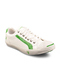

이유 :  어두운 색상의 셔츠와 밝은 색상의 신발은 좋은 대비를 이룹니다.


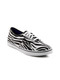

이유 :  색상이 일치하고 캐주얼하게 어우러져 코디하기 좋습니다.


In [57]:
# Select the unique paths for the generated images
paths = list(set(paths))

print("이미지 비교하여 잘 어울리는지 찾아낸 것")
for path in paths:
    # Encode the test image to base64
    suggested_image = encode_image_to_base64(path)
    
    # Check if the items match
    match = json.loads(check_match(encoded_image, suggested_image))
    
    # Display the image and the analysis results
    if match["answer"] == 'yes':
        display(Image(filename=path))
        print("이유 : ", match["reason"])